## Imports

In [1]:
import keras
import numpy as np
import os
import skimage
from PIL import Image
from skimage import measure
import cv2
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Definimos algunas funciones que usaremos
"Function to plot learning and loss results from CNN training"    
def Learning_results(results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

## CARGAMOS LAS IMÁGENES

In [3]:
# LAS SIGUIENTES ÓRDENES GUARDAN UN LISTADO DE LAS IMÁGENES DE LOS DIRECTORIOS ORIGINAL Y MÁSCARA. DEBÉIS REPETIRLO PARA TODOS LOS DIRECTORIOS QUE TENÉIS EN P6_IA

# Neumaticos crackeados
lista_benignos = os.listdir(os.getcwd()+'/TiresOwn/cracked/')
lista_benignos.sort()

# Remove .DS_Store file if exists:
if lista_benignos[0] == '.DS_Store':
    lista_benignos.pop(0)
    

# Neumaticos normales
lista_malignos = os.listdir(os.getcwd()+'/TiresOwn/normal/')
lista_malignos.sort()

# Remove .DS_Store file if exists:
if lista_malignos[0] == '.DS_Store':
    lista_malignos.pop(0)
    

# No son neumaticos o no se ve bien
lista_normales = os.listdir(os.getcwd()+'/TiresOwn/notire/')
lista_normales.sort()

# Remove .DS_Store file if exists:
if lista_normales[0] == '.DS_Store':
    lista_normales.pop(0)



# Confeccionamos las matrices con las imagenes

In [4]:
Images = []

for k1 in lista_benignos:
    img = os.getcwd()+'/TiresOwn/cracked/'+k1
    image1 = img_to_array(load_img(img, target_size=(256,256)))
    Images.append(image1);

for k1 in lista_malignos:
    img = os.getcwd()+'/TiresOwn/normal/'+k1
    image1 = img_to_array(load_img(img, target_size=(256,256)))
    Images.append(image1); 

for k1 in lista_normales:
    img = os.getcwd()+'/TiresOwn/notire/'+k1
    image1 = img_to_array(load_img(img, target_size=(256,256)))
    Images.append(image1); 


In [5]:
# Crear verdad de referencia
Y = np.zeros((len(Images),3))

idx = list(range(len(lista_benignos)))
idx2 = list(range(idx[-1]+1,len(lista_malignos)+idx[-1]+1))
idx3 = list(range(idx2[-1]+1,len(lista_normales)+idx2[-1]+1))

Y[idx,0] = 1
Y[idx2,1] = 1
Y[idx3,2] = 1


## Separar conjuntos de entrenamiento, validacion y test

In [6]:
for k1 in range(len(Images)):

    cropnorm = np.array(Images[k1], dtype=np.float32)
    
    # Normalizamos para tener la imagen en el rango [0,1]
    cropnorm = cropnorm - cropnorm.min() 
    cropnorm = cropnorm / cropnorm.max()
    
    # Almacenamos el crop normaizado
    Images[k1] = np.reshape(cropnorm,(256,256,3))

np.random.seed(71)
idxTrain = np.random.permutation(len(np.array(Images)))
Images = np.array(Images)[idxTrain,:,:,:]
Y = Y[idxTrain,:]

th1 = int(.7*(len(Y)))
th2 = int(.9*(len(Y)))

# Generate train, validation and test sets:
X_train = np.array(Images[0:th1], dtype=np.float32)
X_valid = np.array(Images[th1+1:th2], dtype=np.float32)
X_test = np.array(Images[th2+1:len(Images)], dtype=np.float32)
Y_train = np.array(Y[0:th1], dtype=np.float32)
Y_valid = np.array(Y[th1+1:th2], dtype=np.float32)
Y_test = np.array(Y[th2+1:len(Y)], dtype=np.float32)
del Images, Y


## Model (Transfer Learning)

In [7]:
base_model = VGG16(include_top=False, weights="imagenet", input_tensor=None, input_shape=(None),pooling=None, classes=3, classifier_activation="softmax")
base_model.trainable = False

model = models.Sequential([base_model])
model.add(Flatten())
#model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3, activation='softmax'))
model.build((None,256,256,3))

checkpoint = ModelCheckpoint(os.getcwd() + '/model/tire_texture.hdf5',
                             verbose = 1,
                             save_best_only = True,
                             monitor='val_loss',
                             mode='min')

model.compile(optimizer=Adam(learning_rate = 1e-3), 
              loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Metal device set to: Apple M1 Pro


2022-11-14 17:35:43.244004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-14 17:35:43.244124: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 8, 8, 512)         14714688  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 32768)             0         
_________________________________________________________________
dropout (Dropout)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 98307     
Total params: 14,812,995
Trainable params: 98,307
Non-trainable params: 14,714,688
_________________________________________________________________


2022-11-14 17:35:43.746016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-14 17:35:43.746183: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-14 17:35:43.887758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7619

2022-11-14 17:35:53.114449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 12s 406ms/step - loss: 0.5902 - accuracy: 0.7619 - val_loss: 0.2930 - val_accuracy: 0.8745
Epoch 2/10
29/29 [==============================] - 11s 395ms/step - loss: 0.1382 - accuracy: 0.9491 - val_loss: 0.2281 - val_accuracy: 0.9202
Epoch 3/10
29/29 [==============================] - 12s 408ms/step - loss: 0.0746 - accuracy: 0.9805 - val_loss: 0.2202 - val_accuracy: 0.9049
Epoch 4/10
29/29 [==============================] - 12s 403ms/step - loss: 0.0483 - accuracy: 0.9892 - val_loss: 0.2084 - val_accuracy: 0.9163
Epoch 5/10
29/29 [==============================] - 11s 396ms/step - loss: 0.0410 - accuracy: 0.9935 - val_loss: 0.1990 - val_accuracy: 0.9278
Epoch 6/10
29/29 [==============================] - 11s 385ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.1857 - val_accuracy: 0.9163
Epoch 7/10
29/29 [==============================] - 11s 385ms/step - loss: 0.0178 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 0.9240
Epoch 8/10

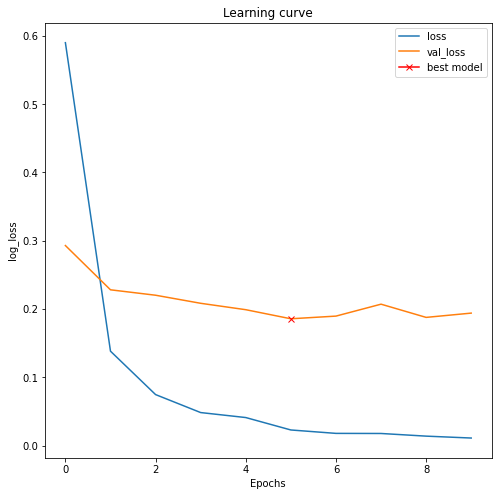

In [8]:
results = model.fit(X_train, Y_train, epochs=10, validation_data=(X_valid, Y_valid))
Learning_results(results)

In [9]:
pred = model.predict(X_test)
clasificacion_test = (np.argmax(pred,axis=1))
referencia = np.argmax(Y_test,axis=1)
porcent_error = np.count_nonzero(clasificacion_test-referencia)/len(clasificacion_test)
print('Porcentaje de error: '+str(porcent_error))

2022-11-14 17:37:37.841686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Porcentaje de error: 0.06060606060606061


In [14]:
pred

array([[1.11875823e-04, 9.99133408e-01, 7.54784036e-04],
       [2.64459755e-02, 9.73538578e-01, 1.54417849e-05],
       [2.77602612e-05, 1.71558803e-03, 9.98256624e-01],
       [1.90747693e-01, 8.09217095e-01, 3.52704337e-05],
       [9.98727500e-01, 1.20244361e-03, 7.00563323e-05],
       [7.38327390e-06, 9.99951243e-01, 4.14078786e-05],
       [3.88860732e-01, 6.07738316e-01, 3.40097025e-03],
       [1.08149034e-04, 9.99869585e-01, 2.22837407e-05],
       [9.40566957e-01, 5.94067425e-02, 2.63554030e-05],
       [9.99131978e-01, 8.66079528e-04, 1.87097476e-06],
       [9.99858499e-01, 1.41167038e-04, 3.67945034e-07],
       [1.37463873e-02, 9.85959232e-01, 2.94372323e-04],
       [7.94457644e-02, 9.20482099e-01, 7.21933975e-05],
       [4.32961527e-03, 9.94646430e-01, 1.02400873e-03],
       [9.99997616e-01, 1.88653860e-06, 5.28254986e-07],
       [7.04881604e-05, 2.81818298e-04, 9.99647617e-01],
       [5.31516969e-01, 4.54674572e-01, 1.38084721e-02],
       [7.73887314e-06, 3.08202

## TEST

Predice clase 1 y la clase correcta es 1


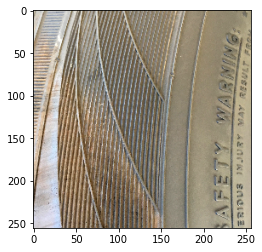

In [19]:
idx = 12
plt.imshow(X_test[idx])
print("Predice clase "+str(referencia[idx])+
      " y la clase correcta es "+str(clasificacion_test[idx]))